In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.103:50828 Dashboard: http://10.148.1.103:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


### Load eulerian field average

In [7]:
eulerian_field = xr.open_dataset('/home1/datawork/zcaspar/diags/avgE.nc')

In [8]:
eulerian_field.u_tmean

<xarray.DataArray 'u_tmean' (y_rho: 145, x_rho: 52)>
array([[-9.349330e-05, -8.183898e-05, -6.563142e-05, ..., -1.443526e-04,
        -1.103099e-04, -9.545680e-05],
       [-3.160502e-04, -3.184435e-04, -3.135324e-04, ..., -2.993994e-04,
        -3.009731e-04, -3.139368e-04],
       [ 1.869998e-04,  2.014761e-04,  2.085459e-04, ...,  2.070478e-04,
         1.922140e-04,  1.860045e-04],
       ...,
       [ 2.810506e-04,  3.861854e-04,  4.094312e-04, ...,  5.902094e-04,
         4.435171e-04,  2.864588e-04],
       [ 5.206109e-04,  4.801026e-04,  4.293966e-04, ...,  2.943191e-04,
         4.259395e-04,  5.262307e-04],
       [ 4.757622e-04,  3.648827e-04,  4.071760e-04, ...,  3.358622e-04,
         5.450167e-04,  5.178528e-04]], dtype=float32)
Coordinates:
    f             (y_rho) float32 ...
  * y_rho         (y_rho) float32 0.0 20000.0 40000.0 ... 2860000.0 2880000.0
    f_rho         (y_rho) float32 ...
  * x_rho         (x_rho) float32 0.0 20000.0 40000.0 ... 1000000.0 1020000.0
    s_rho_slice0  float32 ...

In [5]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

### Drifters trajectories

In [6]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

In [11]:
#test interpolation  on  drifter trajectories : 
import scipy.interpolate as interpolate
df = dr.df.loc[225].compute()

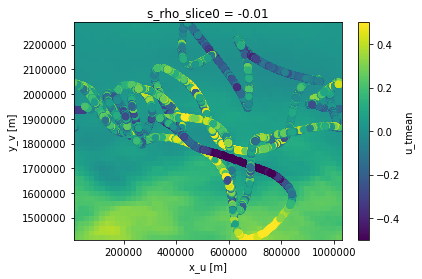

In [38]:
#
eulerian_field.u_tmean.sel(x_rho=slice(df.x.min()*1e3,df.x.max()*1e3),y_rho=slice(df.y.min()*1e3,df.y.max()*1e3)).plot(vmin=-0.5,vmax=0.5,zorder=-1)
plt.scatter(df.x*1e3,df.y*1e3,c=df.u,vmin=-0.5,vmax=0.5)

In [9]:
mean_zon = eulerian_field.mean('x_rho')

In [106]:
uE = mean_zon.u_tmean.sel(y_rho=slice((df.y.min()-100)*1e3,(df.y.max()+100)*1e3))

number of points in y direction in eulerian field :  54
number of points in y direction along drifter trajectory :  71735


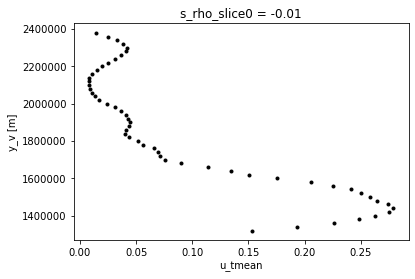

In [108]:
uE.plot.line('k.',y='y_rho')
print('number of points in y direction in eulerian field : ',uE.y_rho.size)
print('number of points in y direction along drifter trajectory : ',df.y.unique().size)

In [130]:
f = interpolate.interp1d(uE.y_rho,uE,kind='cubic')

In [107]:
print(uE.y_rho.max(),df.y.max()*1e3)

<xarray.DataArray 'y_rho' ()>
array(2380000., dtype=float32)
Coordinates:
    s_rho_slice0  float32 -0.01 2289850.52


In [131]:
uinterp = f(df.y*1e3)

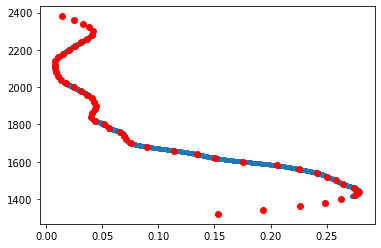

In [132]:
plt.plot(uinterp,df.y,'.')
plt.plot(uE,uE.y_rho*1e-3,'ro')

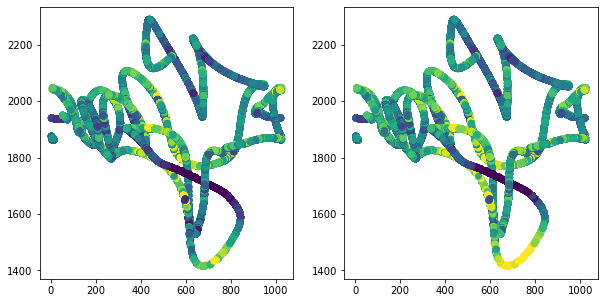

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df.x,df.y,c=(df.u-uinterp),vmin=-0.5,vmax=0.5)
ax[1].scatter(df.x,df.y,c=df.u,vmin=-0.5,vmax=0.5)

### Over all drifters:

In [13]:
mean_zon.u_tmean.interp(y_rho=df.y).to_series()

y_rho
1944.26164   -0.000104
1944.19376   -0.000104
2040.26296   -0.000105
1939.90148   -0.000104
2037.88084   -0.000105
                ...   
2088.40216   -0.000105
1432.96588   -0.000098
2062.11832   -0.000105
2145.40444   -0.000106
1989.18716   -0.000104
Name: u_tmean, Length: 72004, dtype: float64

In [84]:
def interpolate_E(ds,field,columns,dimension='1d'):
    if dimension=='1d':
        avg = field.mean('x_rho').interp(y_rho=ds.y*1e3).get(columns)
        #out = avg.get(columns)#.to_dataframe().drop(columns=['f','s_rho_slice0','f_rho'])
        for var in columns:
            ds[var] = ds[var]-avg[var]
    return ds

In [53]:
E_field = eulerian_field.rename({'u_tmean':'u','v_tmean':'v'})

In [83]:
print(df.u-E_field.mean('x_rho').interp(y_rho=df.y*1e3).u)
print(df.u)

id
225   -0.092060
225   -0.097705
225    0.247292
225    0.096054
225    0.148068
         ...   
225   -0.082062
225    0.006175
225    0.094338
225    0.042051
225    0.036696
Name: u, Length: 72004, dtype: float64
id
225   -0.051960
225   -0.057591
225    0.260277
225    0.137034
225    0.161547
         ...   
225   -0.073579
225    0.283947
225    0.104648
225    0.050819
225    0.064746
Name: u, Length: 72004, dtype: float64


In [85]:
out = interpolate_E(df,E_field,['u','v'])#.rename(columns={'u_tmean':'u','v_tmean':'v'})

In [107]:
tst = dr.df.groupby(dr.df.index).apply(interpolate_E,E_field,['u','v'])#.persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [121]:
def wrap_correlate(DS,columns,T,dt,L,binsize,detrend=True):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,
                                                  cdr.correlate, columns, T, int(T/dt/2),L, detrend=True,dt=dt
                                                 ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

In [110]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50
L = 1026

In [111]:
df_chunked = wrap_correlate(dr.df,['u','v'],T,dt,L,binsize,detrend=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [113]:
uv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(uv.set_index(uv.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uv'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

In [115]:
ds

<xarray.Dataset>
Dimensions:      (lag: 1440, y_bins: 55)
Coordinates:
  * y_bins       (y_bins) float64 25.0 75.0 125.0 ... 2.675e+03 2.725e+03
  * lag          (lag) float64 0.0 0.006944 0.01389 ... 9.979 9.986 9.993
Data variables:
    trend_var_0  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    trend_var_1  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    uv           (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan

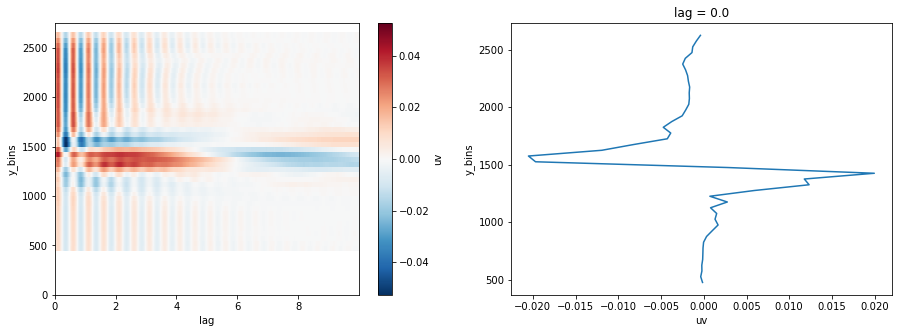

In [116]:
#Normalized autocorrelation 
fig,ax = plt.subplots(1,2,figsize=(15,5))
(ds['uv']).plot(ax=ax[0])
#(ds['uv']/ds['uu'].sel(lag=0.)).plot(ax=ax[1])
ds['uv'].sel(lag=0).plot(y='y_bins',ax=ax[1],label='Variance u')

In [122]:
df_chunked = wrap_correlate(tst,['u','v'],T,dt,L,binsize,detrend=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [136]:
uvbis = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
dsbis = (pd.melt(uvbis.set_index(uv.index.map(lambda v: v.mid))
                 .drop(columns=['id','time','x','y'])
                 .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
                 .rename(columns={'y_cut': 'y_bins', 'value': 'uv'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

In [137]:
dsbis['uv'].lag

<xarray.DataArray 'lag' (lag: 1440)>
array([0.000000e+00, 6.944444e-03, 1.388889e-02, ..., 9.979167e+00,
       9.986111e+00, 9.993056e+00])
Coordinates:
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993

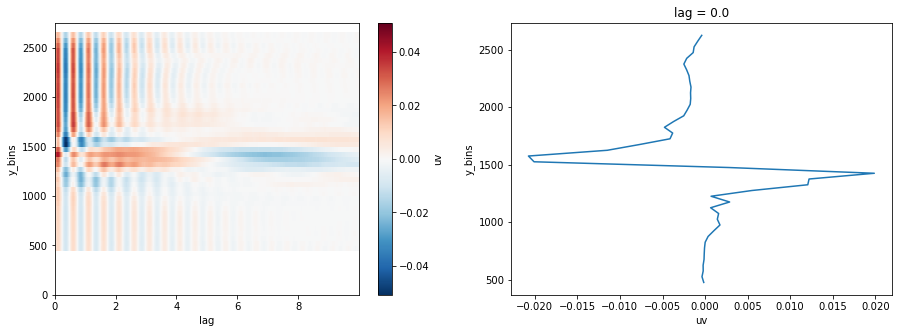

In [138]:
#Normalized autocorrelation 
fig,ax = plt.subplots(1,2,figsize=(15,5))
(dsbis['uv']).plot(ax=ax[0])
#(ds['uv']/ds['uu'].sel(lag=0.)).plot(ax=ax[1])
dsbis['uv'].sel(lag=0).plot(y='y_bins',ax=ax[1],label='Variance u')

In [133]:
cluster.close()